In [1]:
import numpy as np
import pandas as pd
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_poisson_deviance

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

os.chdir('/workspace') # change to the root directory of the project

In [2]:
path = "data/MALDI_IHC/correlations/"
path_results = f"{path}results/"
path_models = f"{path_results}models/"

# Load the data

In [3]:
# Load the normalized MSI data
peaks = pd.read_pickle(f"{path}peaks_standardized_lesion.pkl")
pixels = pd.read_pickle(f"{path}pixels_filtered_lesion.pkl")

peaks.shape, pixels.shape

((1720272, 3492), (1720272, 15))

# Define the densities and a threshold for each pixel density

In [4]:
# Determine the densities of the selected pixels
densities = ["Density_CD8", "Density_Tumor", "Density_Stroma", "Density_Collagen"]

# Get the number of lames and densities
lames = pixels['run'].unique()
n_lames = len(lames)

# Define the threshold for each density
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

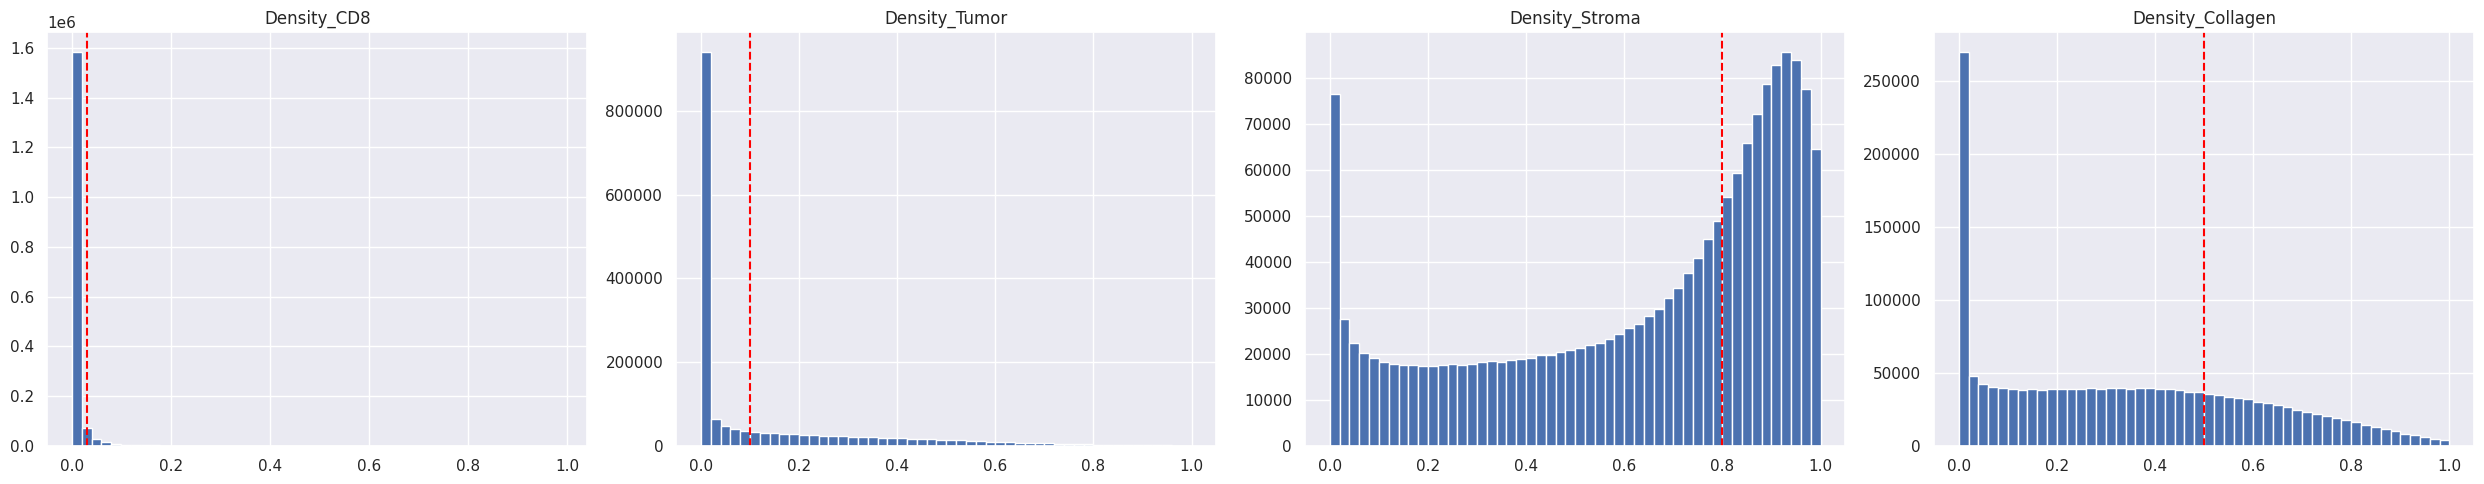

In [5]:
# Plot a histogram of the densities
fig, axes = plt.subplots(1, 4, figsize=(25, 5), tight_layout=True)
for i, (ax, density) in enumerate(zip(axes, densities)):
    ax.hist(pixels[density], bins=50)
    ax.axvline(threshold[density], color='red', linestyle='--')
    ax.set_title(density)
    # ax.set_yscale('log')
plt.show()

# Clean the Defective pixels

In [6]:
# Exclude the pixels with defects
peaks = peaks[pixels["Density_Defects"] < 0.1]
pixels = pixels[pixels["Density_Defects"] < 0.1]

# Reset the index
peaks.reset_index(drop=True, inplace=True)
pixels.reset_index(drop=True, inplace=True)

# Split the data into training and testing sets

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(peaks.values,
                                                    pixels['Density_CD8'].values,
                                                    test_size=0.05,
                                                    random_state=42)

# Transform the target variable

In [8]:
# Compute the area of the pixels
MALDI_PIXEL_LENGTH = 50  # Pixel length of the MALDI images
IMAGE_PIXEL_LENGTH = 0.2631  # Pixel length of the images in micrometers
l = int((MALDI_PIXEL_LENGTH / IMAGE_PIXEL_LENGTH) / 2)
AREA = (2*l)**2  # Area of the pixels in square micrometers

# Transform the target to pixel counts instead of density
y_train_cts = (y_train * AREA).astype(int)
y_test_cts = (y_test * AREA).astype(int)

# Perform a Poisson linear regression

In [9]:
# Create a poisson regression model
model_poisson = PoissonRegressor(alpha=1, max_iter=10**6, tol=1e-6)

# Train the model
model_poisson.fit(X_train, y_train_cts)

PoissonRegressor(alpha=1, max_iter=1000000, tol=1e-06)

R-squared (Train): 0.15
R-squared (Test): 0.02
Mean Squared Error (Train): 3.68e-04
Mean Squared Error (Test): 4.16e-04
Deviance (Train): 1.44e-02
Deviance (Test): 1.47e-02


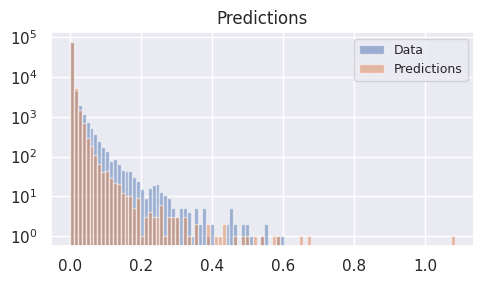

In [10]:
# Make predictions
y_pred_train = model_poisson.predict(X_train)
y_pred_test = model_poisson.predict(X_test)

# Transform the predictions to density
y_pred_train = y_pred_train / AREA
y_pred_test = y_pred_test / AREA

# Compute R-squared
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# Compute the deviance
deviance_train = mean_poisson_deviance(y_train, y_pred_train)
deviance_test = mean_poisson_deviance(y_test, y_pred_test)

print(f"Deviance (Train): {deviance_train:.2e}")
print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 100)
ax.hist(y_test, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
ax.set_yscale('log')
# ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

In [3]:
# Load the models trained on the rms target
model_lasso = joblib.load(f"{path_models}model_lasso.joblib")
model_en = joblib.load(f"{path_models}model_en.joblib")

In [13]:
# Count the non-zero coefficients
print (f"Number of features: {len(peaks.columns)}")
print(f"Number of non-zero coefficients:")
print(f"Lasso Regression: {np.sum(model_lasso.coef_ != 0)}") 
print(f"Elastic Net: {np.sum(model_en.coef_ != 0)}")
print(f"Poisson Regression: {np.sum(model_poisson.coef_ != 0)}")

Number of features: 3492
Number of non-zero coefficients:
Lasso Regression: 122
Elastic Net: 265
Poisson Regression: 3492


In [14]:
# Extract the non-zero masses in the Lasso and Elastic Net models
masses_lasso = peaks.columns.values[model_lasso.coef_ != 0].astype(float)
masses_en = peaks.columns.values[model_en.coef_ != 0].astype(float)

In [15]:
# Select the peaks that are in the Lasso
peaks_lasso = peaks.loc[:, peaks.columns.values[model_lasso.coef_ != 0]]

X_train_lasso = X_train[:, model_lasso.coef_ != 0]
X_test_lasso = X_test[:, model_lasso.coef_ != 0]

In [15]:
# Create a poisson regression model
model_poisson_lasso = PoissonRegressor(alpha=0.1, max_iter=10**6, tol=1e-6)

# Train the model
model_poisson_lasso.fit(X_train_lasso, y_train_cts)

PoissonRegressor(alpha=0.1, max_iter=1000000, tol=1e-06)

R-squared (Train): 0.09
R-squared (Test): 0.10
Mean Squared Error (Train): 3.97e-04
Mean Squared Error (Test): 3.82e-04
Deviance (Train): 1.59e-02
Deviance (Test): 1.57e-02


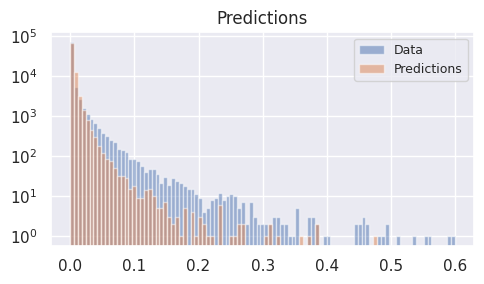

In [17]:
# Make predictions
y_pred_train = model_poisson_lasso.predict(X_train_lasso)
y_pred_test = model_poisson_lasso.predict(X_test_lasso)

# Transform the predictions to density
y_pred_train = y_pred_train / AREA
y_pred_test = y_pred_test / AREA

# Compute R-squared
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# Compute the deviance
deviance_train = mean_poisson_deviance(y_train, y_pred_train)
deviance_test = mean_poisson_deviance(y_test, y_pred_test)

print(f"Deviance (Train): {deviance_train:.2e}")
print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 100)
ax.hist(y_test, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
ax.set_yscale('log')
# ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

# Save the models

In [22]:
# save the models
joblib.dump(model_poisson, f"{path_models}model_poisson_cts.joblib")
joblib.dump(model_poisson_lasso, f"{path_models}model_poisson_lasso_cts.joblib")

['data/MALDI_IHC/correlations/results/models/model_poisson_lasso_cts.joblib']

In [4]:
# load the models
model_poisson = joblib.load(f"{path_models}model_poisson_cts.joblib")
model_poisson_lasso = joblib.load(f"{path_models}model_poisson_lasso_cts.joblib")

In [5]:
# Reload the peaks and pixels data
peaks = pd.read_pickle(f"{path}peaks_standardized.pkl")
pixels = pd.read_pickle(f"{path}pixels_filtered.pkl")

# Exclude the pixels with defects
peaks = peaks[pixels["Density_Defects"] < 0.1]
pixels = pixels[pixels["Density_Defects"] < 0.1]

# Reset the index
peaks.reset_index(drop=True, inplace=True)
pixels.reset_index(drop=True, inplace=True)

In [6]:
# Select the peaks that are in the Lasso
peaks_lasso = peaks.loc[:, peaks.columns.values[model_lasso.coef_ != 0]]

In [13]:
# Save the peaks and pixels data
peaks_lasso.to_pickle(f"{path}peaks_standardized_lasso.pkl")
pixels.to_pickle(f"{path}pixels_filtered_lasso.pkl")

In [13]:
# Apply the weights to all the pixels peaks (lame by lame)
for lame in lames:
    peaks_lame = peaks[pixels['run'] == lame]
    pixels.loc[pixels['run'] == lame, 'Reg_Poisson_CD8'] = np.clip(model_poisson.predict(peaks_lame.values) / AREA, 0, 1)

# Apply the weights to all the pixels lasso peaks
pixels['Reg_Poisson_Lasso_CD8'] = np.clip(model_poisson_lasso.predict(peaks_lasso.values) / AREA, 0, 1)

In [14]:
predictions = ['Density_CD8', 'Reg_Poisson_CD8', 'Reg_Poisson_Lasso_CD8']

# Plot the predicted CD8 density for each lame compared to the original CD8 density
fig, axs = plt.subplots(nrows=n_lames, ncols=3, figsize=(15, 100), tight_layout=True)

for i, lame in enumerate(lames):
    pixels_lame = pixels[pixels['run'] == lame]
    max_density = np.quantile(pixels_lame['Density_CD8'], 0.99)
    for j, prediction in enumerate(predictions):
        axs[i, j].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=pixels_lame[prediction],
                          s=(pixels_lame['x_warped'].max() - pixels_lame['x_warped'].min()) / len(pixels_lame),
                          marker='s', cmap='viridis', vmin=0, vmax=np.quantile(pixels_lame[prediction], 0.99))
        if i == 0: axs[i, j].set_title(prediction)
        if j == 0: axs[i, j].set_ylabel(lame)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].axis('equal')
        axs[i, j].invert_yaxis()
        fig.colorbar(axs[i, j].collections[0], ax=axs[i, j])
plt.savefig(f"{path_results}predictions_CD8_Poisson_cts.png")
plt.close()

In [15]:
predictions = ['Density_CD8', 'Reg_Poisson_CD8', 'Reg_Poisson_Lasso_CD8']

# Plot the predicted CD8 density for each lame compared to the original CD8 density
fig, axs = plt.subplots(nrows=n_lames, ncols=3, figsize=(15, 100), tight_layout=True)

for i, lame in enumerate(lames):
    pixels_lame = pixels[pixels['run'] == lame]
    pixels_lame = pixels_lame[pixels_lame['Density_Lesion'] > 0.5]
    max_density = np.quantile(pixels_lame['Density_CD8'], 0.99)
    for j, prediction in enumerate(predictions):
        axs[i, j].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=pixels_lame[prediction],
                          s=(pixels_lame['x_warped'].max() - pixels_lame['x_warped'].min()) / len(pixels_lame),
                          marker='s', cmap='viridis', vmin=0, vmax=np.quantile(pixels_lame[prediction], 0.99))
        if i == 0: axs[i, j].set_title(prediction)
        if j == 0: axs[i, j].set_ylabel(lame)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].axis('equal')
        axs[i, j].invert_yaxis()
        fig.colorbar(axs[i, j].collections[0], ax=axs[i, j])
plt.savefig(f"{path_results}predictions_CD8_Poisson_lesion_cts.png")
plt.close()